# Implementing a Recommender System with SageMaker, MXNet, and Gluon
_**Making Video Recommendations Using Neural Networks and Embeddings**_

--- 

---

*This work is based on content from the [Cyrus Vahid's 2017 re:Invent Talk](https://github.com/cyrusmvahid/gluontutorials/blob/master/recommendations/MLPMF.ipynb)*


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Move Data](#Move-Data)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Background

In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

Matrix factorization has been extended and genarlized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon video dataset.  It will start by exploring our data in the notebook and even training a model on a sample of the data.  Later we'll expand to the full dataset and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.

---

## Setup

_This notebook was created and tested on an ml.p2.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
bucket = 'layup232345'
prefix = 'sagemaker/DEMO-gluon-recsys'

import sagemaker
role = sagemaker.get_execution_role()

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [2]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt

---
## Data

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [3]:
# !mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

mkdir: cannot create directory ‘/tmp/recsys/’: File exists
download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [4]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t',error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


We can see this dataset includes information like:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

For this example, let's limit ourselves to `customer_id`, `product_id`, and `star_rating`.  Including additional features in our recommendation system could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `product_title` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

In [5]:
df = df[['customer_id', 'product_id', 'star_rating', 'product_title']]

Because most people haven't seen most videos, and people rate fewer videos than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [6]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64


As we can see, only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

### Clean

Let's filter out this long tail.

In [7]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [8]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [9]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,product_title,user,item
0,27072354,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,10463,107
1,16030865,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,489,107
2,44025160,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,32100,107
3,18602179,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,2237,107
4,14424972,B008LOVIIK,5,Masterpiece: Inspector Lewis Season 5,32340,107


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [10]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [11]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['star_rating'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['star_rating'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

---

## Train Locally

### Define Network

Let's start by defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [12]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

In [13]:
num_embeddings = 64

net = MFBlock(max_users=customer_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


### Set Parameters

Let's initialize network weights and set our optimization parameters.

In [21]:
mx.gpu?

In [15]:
# Initialize network parameters
ctx = mx.gpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

In [16]:
trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

### Execute

Let's define a function to carry out the training of our neural network.

In [17]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):
        
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
    print("end of training")
    return net

Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

In [18]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

Now, let's train for a few epochs.

In [19]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.1478585849007763. 1.1478933943695282
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.015684979429758. 1.0157101604330587
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 0.958374810052583. 0.9584383050007607
end of training
CPU times: user 8min 55s, sys: 11.5 s, total: 9min 6s
Wall time: 8min 34s


#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [20]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False)

,item,product_id,u6_predictions
1505,1505,B008ZXT1KO,5.651490
641,641,B0088WLEVG,5.634015
977,977,B006885EFE,5.575847
3223,3223,B00E9HE4M0,5.568130
2856,2856,B004LQGXPA,5.563286
3600,3600,B00YMIN7RE,5.552298
2965,2965,B00H8XP4W6,5.543756
19437,19437,B006RM32FA,5.518327
656,656,B003X1BOIU,5.516575
172,172,B00RT7FSQI,5.515037


Now let's compare this to the predictions for another user (we'll try user #7).

In [21]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False)

,item,product_id,u6_predictions,u7_predictions
1505,1505,B008ZXT1KO,5.651490,4.007372
10647,10647,B004BZG1FI,5.513137,4.003162
1014,1014,B003YV8IHE,5.512478,3.984093
1291,1291,B00L0Y5Y8I,5.425984,3.982222
28364,28364,B004W1GD72,5.480252,3.981879
656,656,B003X1BOIU,5.516575,3.977365
3600,3600,B00YMIN7RE,5.552298,3.976738
2856,2856,B004LQGXPA,5.563286,3.971005
34754,34754,B00VXW8NI0,5.428771,3.970542
6090,6090,B001GQLSVW,5.334682,3.963368


The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

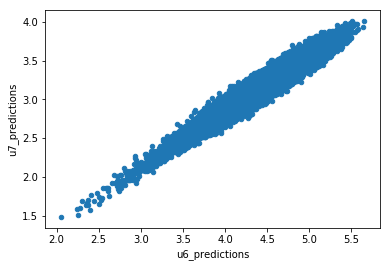

In [22]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [23]:
!cat recommender.py

import logging
import json
import time
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import numpy as np

os.system('pip install pandas')
import pandas as pd

logging.basicConfig(level=logging.DEBUG)

#########
# Globals
#########

batch_size = 1024


##########
# Training
##########

def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):
    
    # get data
    training_dir = channel_input_dirs['train']
    train_iter, test_iter, customer_index, product_index = prepare_train_data(training_dir)
    
    # get hyperparameters
    num_embeddings = hyperparameters.get('num_embeddings', 64)
    opt = hyperparameters.get('opt', 'sgd')
    lr = hyperparameters.get('lr', 0.02)
    momentum = hyperparameters.get('momentum', 0.9)
    wd = hyperparameters.get('wd', 0.)
    epochs = hyperparameters.get('epochs', 5)

    # define net
    ctx = mx.gpu()

    net = MFBlock(max_users=customer_index.shape[0], 
                  max_it

### Evaluate

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [27]:
%%time

import recommender

local_test_net, local_customer_index, local_product_index = recommender.train(
    {'train': '/tmp/recsys/'}, 
    {'num_embeddings': 64, 
     'opt': 'sgd', 
     'lr': 0.02, 
     'momentum': 0.9, 
     'wd': 0.,
     'epochs': 3},
    ['local'],
    1)

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.1765037772664986. 1.1764914449230133
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.034049305426647. 1.0340361617713336
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 0.9965512728786089. 0.9965402909179232
end of training
CPU times: user 10min 14s, sys: 13.3 s, total: 10min 27s
Wall time: 9min 56s


---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.